In [1]:
import functools
import jax
import os

from datetime import datetime
from jax import numpy as jp
import matplotlib.pyplot as plt

from IPython.display import HTML, clear_output

import brax

import flax
from brax import envs
from brax.io import model
from brax.io import json
from brax.io import html
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import train as sac

from lib.irl.gail import *
from lib.irl.utils import *
from lib.utils.trajectory import create_inference_function

In [2]:
inference_fn=create_inference_function()

In [3]:
env = envs.get_environment(env_name='humanoid',
                           backend='mjx')

In [4]:
disc_path='weights/discriminator.pkl'

In [5]:
discriminator_config=load_config(disc_path.replace('discriminator', 'discriminator_config'))
discriminator=load_model(Discriminator, jax.random.PRNGKey(0), disc_path, **discriminator_config)
discriminator.eval()
relu=nnx.relu

In [39]:
jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)

rollout = []
rewards_expert=[]
rewards_amateur=[]
rng = jax.random.PRNGKey(seed=1)
previous_state = jit_env_reset(rng=rng)
while previous_state.done.item()<1:
    rollout.append(previous_state.pipeline_state)
    act_rng, rng = jax.random.split(rng)
    act, _ = jit_inference_fn(previous_state.obs, act_rng)
    current_state = jit_env_step(previous_state, act)
    rewards_expert.append(current_state.reward)
    amateur_reward=relu(discriminator(jp.concatenate((previous_state.pipeline_state.q, previous_state.pipeline_state.qd, current_state.pipeline_state.q, current_state.pipeline_state.qd))))
    rewards_amateur.append(amateur_reward)
    previous_state=current_state


In [40]:
from lib.utils.viz import *

create_interactive_rollout(env=env, rollout=rollout, headless=False)

Rollout successful, saved at /home/mukundan/Desktop/Summer_SEM/imitation_learning/temp.html


Opening in existing browser session.


In [34]:
rewards_expert=jp.cumsum(jp.stack(rewards_expert))
rewards_amateur=jp.cumsum(jp.stack(rewards_amateur))

# rewards_expert=jp.stack(rewards_expert)
# rewards_amateur=jp.stack(rewards_amateur)

In [35]:
rewards_amateur[-1]

Array(12904.412, dtype=float32)

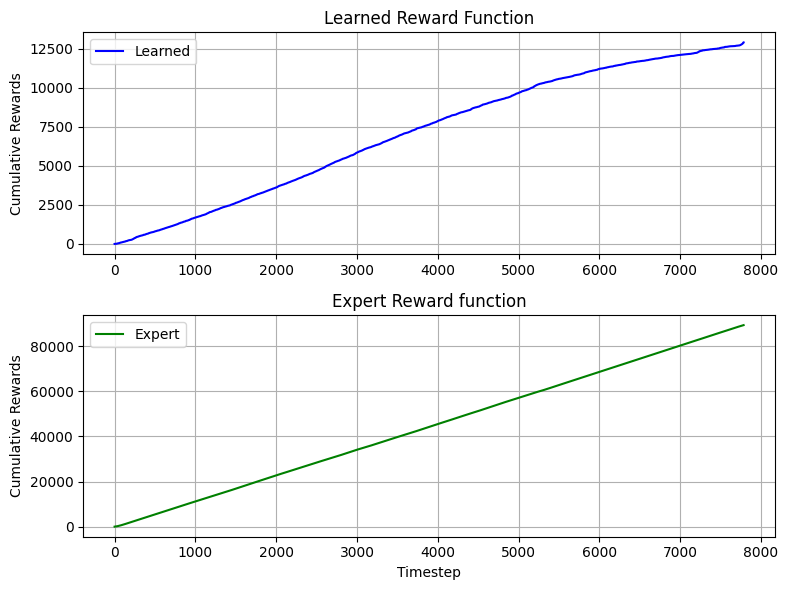

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Example arrays
x = np.linspace(0, len(rewards_amateur))
y1 = rewards_amateur
y2 = rewards_expert

fig, axs = plt.subplots(2, 1, figsize=(8, 6))  # 2 rows, 1 column

# First graph
axs[0].plot(y1, label='Learned', color='blue')
axs[0].set_title('Learned Reward Function')
# axs[0].set_xlabel('Timestep')
axs[0].set_ylabel('Cumulative Rewards')
axs[0].grid(True)
axs[0].legend()

# Second graph
axs[1].plot(y2, label='Expert', color='green')
axs[1].set_title('Expert Reward function')
axs[1].set_xlabel('Timestep')
axs[1].set_ylabel('Cumulative Rewards')
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()

# # Plot
# plt.figure(figsize=(8, 4))
# plt.plot(y1, label='Learned', linewidth=2)
# plt.plot(y2, label='Expert', linewidth=2)
# plt.xlabel('Timestep')
# plt.ylabel('Cumulative Rewards')
# plt.title('Comparative rewards')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()
# plt.savefig('comparative_rewards.png')